In [3]:

from scipy.integrate import ode
import SundialsPy as SP
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, List, Dict, Any, Optional
import os
from datetime import datetime
import time
from tqdm import tqdm
from utils import *

In [4]:
def compare_solver_performance(bdf_results, comparison_results, comparison_names=["Comparison"], 
                             temperature=None, pressure=None, species_to_track=None, switch_points=None, metric='mean'):
    """
    Create comprehensive performance comparison plots between BDF reference and comparison solver.
    
    Args:
        bdf_results: Dictionary containing BDF solver results with keys:
                    - 'reference': high precision reference solution
                    - 'bdf_results_low': low tolerance BDF results  
                    - 'bdf_results_high': high tolerance BDF results
        comparison_results: List of Results dictionary for the comparison solver
        comparison_names: List of names for the comparison solver in plots
        temperature: Temperature for plot titles
        pressure: Pressure for plot titles
        species_to_track: List of species for analysis
        switch_points: List of switch points for the comparison solver
    """
    
    # Define plotting parameters
    line_styles = ['-', '--', '-.', ':']
    colors = ['red', 'purple', 'orange']
    
    # Helper function for running average
    def running_average_forward(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    # 1. CPU Time per Step Comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
        ax.plot(running_average_forward(comparison_result['cpu_times'], 1000),
                label=f"{comparison_name} (Total: {np.sum(comparison_result['cpu_times']):.2e}s)",
                linestyle='-', linewidth=2.5, color=colors[i])
    
    ax.plot(running_average_forward(bdf_results['reference']['cpu_times'], 1000),
            label=f"Reference BDF (1e-12,1e-10) (Total: {np.sum(bdf_results['reference']['cpu_times']):.2e}s)",
            linestyle='-', linewidth=3, color='blue')
    
    ax.plot(running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000),
            label=f"BDF (1e-6,1e-8) (Total: {np.sum(bdf_results['bdf_results_low']['cpu_times']):.2e}s)",
            linestyle='-', linewidth=2, color='green')
    
    ax.plot(running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000),
            label=f"BDF (1e-8,1e-10) (Total: {np.sum(bdf_results['bdf_results_high']['cpu_times']):.2e}s)",
            linestyle='-', linewidth=2, color='black')

    if switch_points:
        for switch_point in switch_points:  
            ax.axvline(x=switch_point, color='red', linestyle='--', linewidth=2, label=f'SP ({switch_point})')
    
    ax.set_xlabel('Step Number (×1000)', fontsize=14)
    ax.set_ylabel('CPU Time per Step (s)', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    title = f'CPU Time per Step Comparison'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. CPU Time Ratio to Reference
    fig, ax = plt.subplots(figsize=(12, 8))
    
    reference_times = running_average_forward(bdf_results['reference']['cpu_times'], 1000)
    
    # Comparison solver ratio
    for i, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
        comp_times = running_average_forward(comparison_result['cpu_times'], 1000)
        comp_ratio = comp_times / reference_times[:len(comp_times)]
        ax.plot(comp_ratio, label=f"{comparison_name} (Mean: {np.mean(comp_ratio):.2e})",
                linestyle='--', linewidth=2.5, color=colors[i])
    
    # BDF ratios
    bdf_low_times = running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000)
    bdf_low_ratio = bdf_low_times / reference_times[:len(bdf_low_times)]
    ax.plot(bdf_low_ratio, label=f'BDF (1e-6,1e-8) (Mean: {np.mean(bdf_low_ratio):.2e})',
            linestyle='-', linewidth=2, color='green')
    
    bdf_high_times = running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000)
    bdf_high_ratio = bdf_high_times / reference_times[:len(bdf_high_times)]
    ax.plot(bdf_high_ratio, label=f'BDF (1e-8,1e-10) (Mean: {np.mean(bdf_high_ratio):.2e})',
            linestyle='-', linewidth=2, color='black')
    
    # Reference line
    ax.plot(np.ones_like(reference_times), label='Reference BDF (1e-12,1e-10)',
            linestyle='-', linewidth=3, color='blue')
    
    if switch_points:
        for switch_point in switch_points:  
            ax.axvline(x=switch_point, color='red', linestyle='--', linewidth=2, label=f'SP ({switch_point})')
    
    ax.set_yscale('log')
    ax.set_xlabel('Step Number (×1000)', fontsize=14)
    ax.set_ylabel('CPU Time Ratio to Reference', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    title = f'CPU Time Efficiency Comparison'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Overall CPU Time Bar Chart
    fig, ax = plt.subplots(figsize=(10, 8))
    
    reference_time = bdf_results['reference']['cpu_times']
    
    solver_names = ['BDF\n(1e-6,1e-8)', 'BDF\n(1e-8,1e-10)']
    relative_times = [
        np.sum(bdf_results['bdf_results_low']['cpu_times']) / np.sum(reference_time[:len(bdf_results['bdf_results_low']['cpu_times'])]),
        np.sum(bdf_results['bdf_results_high']['cpu_times']) / np.sum(reference_time[:len(bdf_results['bdf_results_high']['cpu_times'])]),
    ]
    chosen_colors = []
    for i, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
        relative_times.append(np.sum(comparison_result['cpu_times']) / np.sum(reference_time[:len(comparison_result['cpu_times'])]))
        solver_names.append(comparison_name)    
        chosen_colors.append(colors[i])
    
    bars = ax.bar(solver_names, relative_times, 
                  color=['green', 'black'] + chosen_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, relative_times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.2f}×', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.axhline(y=1.0, color='blue', linestyle='--', linewidth=2, label='Reference BDF (1e-12,1e-10)')
    ax.set_ylabel('Relative CPU Time', fontsize=14)
    ax.set_xlabel('Solver Configuration', fontsize=14)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    
    title = f'Overall CPU Time Efficiency'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Temperature Profiles
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
        ax.plot(comparison_result['temperatures'], label=comparison_name,
                linestyle='-', linewidth=2.5, color=colors[i])
    ax.plot(bdf_results['reference']['temperatures'], label='Reference BDF (1e-12,1e-10)',
            linestyle='-', linewidth=3, color='blue')
    ax.plot(bdf_results['bdf_results_low']['temperatures'], label='BDF (1e-6,1e-8)',
            linestyle='-', linewidth=2, color='green')
    ax.plot(bdf_results['bdf_results_high']['temperatures'], label='BDF (1e-8,1e-10)',
            linestyle='-', linewidth=2, color='black')
    
    if switch_points:
        for switch_point in switch_points:  
            ax.axvline(x=switch_point, color='red', linestyle='--', linewidth=2, label=f'SP ({switch_point})')
    
    ax.set_xlabel('Step Number', fontsize=14)
    ax.set_ylabel('Temperature (K)', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    title = f'Temperature Profile Comparison'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Species Profiles 3x3 Plot
    species_to_plot = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
    if species_to_track and len(species_to_track) == 9:
        fig, axes = plt.subplots(3, 3, figsize=(20, 18))
        
        # Create legend handles for all plots
        legend_handles = []
        legend_labels = []
        
        for i, specie_name in enumerate(species_to_track):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            
            # Plot comparison results
            for j, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
                if specie_name == 'temperature':
                    specie_data = comparison_result['temperatures']
                else:
                    specie_data = comparison_result['species_profiles'][specie_name]
                line = ax.plot(np.log10(np.maximum(specie_data, 1e-20)), 
                           linestyle='-', linewidth=2.5, color=colors[j])
                if i == 0:  # Store legend handles from first subplot
                    legend_handles.append(line[0])
                    legend_labels.append(comparison_name)
            
            # Plot BDF results
            if specie_name == 'temperature':
                specie_data = bdf_results['reference']['temperatures']
            else:
                specie_data = bdf_results['reference']['species_profiles'][specie_name]
            line = ax.plot(np.log10(np.maximum(specie_data, 1e-20)), 
                       linestyle='-', linewidth=3, color='blue')
            if i == 0:
                legend_handles.append(line[0])
                legend_labels.append('Reference BDF (1e-12,1e-10)')
            
            if specie_name == 'temperature':
                specie_data = bdf_results['bdf_results_low']['temperatures']
            else:
                specie_data = bdf_results['bdf_results_low']['species_profiles'][specie_name]
            line = ax.plot(np.log10(np.maximum(specie_data, 1e-20)), 
                       linestyle='-', linewidth=2, color='green')
            if i == 0:
                legend_handles.append(line[0])
                legend_labels.append('BDF (1e-6,1e-8)')
            
            if specie_name == 'temperature':
                specie_data = bdf_results['bdf_results_high']['temperatures']
            else:
                specie_data = bdf_results['bdf_results_high']['species_profiles'][specie_name]
            line = ax.plot(np.log10(np.maximum(specie_data, 1e-20)), 
                       linestyle='-', linewidth=2, color='black')
            if i == 0:
                legend_handles.append(line[0])
                legend_labels.append('BDF (1e-8,1e-10)')
            
            # Add switch points
            if switch_points:
                for switch_point in switch_points:
                    ax.axvline(x=switch_point, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
            
            ax.set_xlabel('Step Number', fontsize=12)
            ax.set_ylabel('Mole Fraction', fontsize=12)
            ax.set_title(f'{specie_name.upper()}', fontsize=14, fontweight='bold')
            # ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=10)
        
        # Add overall title
        main_title = 'Species Profiles Comparison'
        if temperature and pressure:
            main_title += f' - {temperature}K, {pressure:.0e}Pa'
        fig.suptitle(main_title, fontsize=20, fontweight='bold', y=0.95)
        
        # Add a single legend at the bottom center
        fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, 0.02), 
                  loc='lower center', fontsize=12, frameon=True, fancybox=True, shadow=True, ncol=len(legend_labels))
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.90, bottom=0.08)
        plt.show()
    
    # 6. Species Concentration Analysis
    if species_to_track:
        def calculate_maximum_species_conc(data, ref_data, species_names, metric='mean'):
            max_concentrations = {}
            for specie in species_names:
                if specie == 'temperature':
                    max_conc = np.max(data['temperatures']) if metric == 'max' else np.mean(data['temperatures'])
                    ref_max_conc = np.max(ref_data['temperatures'][:len(data['temperatures'])]) if metric == 'max' else np.mean(ref_data['temperatures'][:len(data['temperatures'])])
                else:
                    max_conc = np.max(data['species_profiles'][specie]) if metric == 'max' else np.mean(data['species_profiles'][specie])
                    ref_max_conc = np.max(ref_data['species_profiles'][specie][:len(data['species_profiles'][specie])]) if metric == 'max' else np.mean(ref_data['species_profiles'][specie][:len(data['species_profiles'][specie])])
                max_concentrations[specie] = (max_conc, ref_max_conc)
            return max_concentrations
        
        species_to_plot = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
        
        # Calculate concentration ratios
        bdf_max_conc_low = calculate_maximum_species_conc(
            bdf_results['bdf_results_low'], bdf_results['reference'], species_to_plot, metric)
        bdf_max_conc_high = calculate_maximum_species_conc(
            bdf_results['bdf_results_high'], bdf_results['reference'], species_to_plot, metric)
        comp_max_concs = []
        for comparison_name, comparison_result in zip(comparison_names, comparison_results):
            comp_max_conc = calculate_maximum_species_conc(
                comparison_result, bdf_results['reference'], species_to_plot, metric)
            comp_max_concs.append(comp_max_conc)
        # Create species concentration ratio plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        x_positions = np.arange(len(species_to_plot))
        width = 0.25
        
        # Calculate ratios
        bdf_ratios_low = [bdf_max_conc_low[sp][0] / bdf_max_conc_low[sp][1] for sp in species_to_plot]
        bdf_ratios_high = [bdf_max_conc_high[sp][0] / bdf_max_conc_high[sp][1] for sp in species_to_plot]
        comp_ratios = [comp_max_concs[i][sp][0] / comp_max_concs[i][sp][1] for i in range(len(comparison_names)) for sp in species_to_plot]
        
        # Create grouped bar chart with spacing
        spacing = 0.05  # Add space between groups
        group_width = width * (2 + len(comparison_names)) + spacing
        
        ax.bar(x_positions - width - spacing/2, bdf_ratios_low, width, label='BDF (1e-6,1e-8)', 
               color='green', alpha=0.7, edgecolor='black')
        ax.bar(x_positions - spacing/2, bdf_ratios_high, width, label='BDF (1e-8,1e-10)', 
               color='black', alpha=0.7, edgecolor='black')
        for i, comparison_name in enumerate(comparison_names):
            ax.bar(x_positions + width * (i+1) - spacing/2, comp_ratios[i], width, label=comparison_name, 
                   color=colors[i], alpha=0.7, edgecolor='black')

        # plot a horizontal line at y=1
        ax.axhline(y=1, color='red', linestyle='--', linewidth=4, label='Reference BDF (1e-12,1e-10)')
        
        ax.set_xlabel('Species', fontsize=14)
        ax.set_ylabel(f'{metric.capitalize()} Concentration Ratio (Solver/Reference)', fontsize=14)
        ax.set_yscale('log')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(species_to_plot, rotation=45, ha='right', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(labelsize=12)
        
        title = f'Species Concentration Accuracy Comparison ({metric.capitalize()})'
        if temperature and pressure:
            title += f' - {temperature}K, {pressure:.0e}Pa'
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.show()




In [5]:
def compare_single_species_performance(bdf_results, comparison_results, comparison_names=["Comparison"], 
                                     species_name='h2o', temperature=None, pressure=None, 
                                     switch_points=None, metric='mean'):
    """
    Create high-quality comparison plots for a single species between BDF reference and comparison solvers.
    
    Args:
        bdf_results: Dictionary containing BDF solver results with keys:
                    - 'reference': high precision reference solution
                    - 'bdf_results_low': low tolerance BDF results  
                    - 'bdf_results_high': high tolerance BDF results
        comparison_results: List of Results dictionary for the comparison solver
        comparison_names: List of names for the comparison solver in plots
        species_name: Single species name to analyze
        temperature: Temperature for plot titles
        pressure: Pressure for plot titles
        switch_points: List of switch points for the comparison solver
        metric: 'mean' or 'max' for concentration analysis
    """
    
    # Define plotting parameters
    colors = ['red', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    # Create 2x1 subplot layout with better sizing
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
    
    # Plot 1: Species Profile Comparison
    for i, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
        if species_name == 'temperature':
            species_data = comparison_result['temperatures']
            ylabel = 'Temperature (K)'
        else:
            species_data = comparison_result['species_profiles'][species_name]
            ylabel = 'Log₁₀(Mole Fraction)'
        
        if species_name == 'temperature':
            ax1.plot(species_data, label=comparison_name,
                    linestyle='-', linewidth=2.5, color=colors[i])
        else:
            ax1.plot(np.log10(np.maximum(species_data, 1e-20)), label=comparison_name,
                    linestyle='-', linewidth=2.5, color=colors[i])
    
    # Plot BDF results
    if species_name == 'temperature':
        ref_data = bdf_results['reference']['temperatures']
        bdf_low_data = bdf_results['bdf_results_low']['temperatures']
        bdf_high_data = bdf_results['bdf_results_high']['temperatures']
    else:
        ref_data = bdf_results['reference']['species_profiles'][species_name]
        bdf_low_data = bdf_results['bdf_results_low']['species_profiles'][species_name]
        bdf_high_data = bdf_results['bdf_results_high']['species_profiles'][species_name]
    
    if species_name == 'temperature':
        ax1.plot(ref_data, label='Reference BDF (1e-12,1e-10)',
                linestyle='-', linewidth=3, color='blue')
        ax1.plot(bdf_low_data, label='BDF (1e-6,1e-8)',
                linestyle='-', linewidth=2, color='green')
        ax1.plot(bdf_high_data, label='BDF (1e-8,1e-10)',
                linestyle='-', linewidth=2, color='black')
    else:
        ax1.plot(np.log10(np.maximum(ref_data, 1e-20)), label='Reference BDF (1e-12,1e-10)',
                linestyle='-', linewidth=3, color='blue')
        ax1.plot(np.log10(np.maximum(bdf_low_data, 1e-20)), label='BDF (1e-6,1e-8)',
                linestyle='-', linewidth=2, color='green')
        ax1.plot(np.log10(np.maximum(bdf_high_data, 1e-20)), label='BDF (1e-8,1e-10)',
                linestyle='-', linewidth=2, color='black')
    
    # Add switch points
    if switch_points:
        for switch_point in switch_points:
            ax1.axvline(x=switch_point, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    ax1.set_xlabel('Step Number', fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    ax1.set_title(f'{species_name.upper()} Profile Comparison', fontsize=16, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=12)
    
    # Plot 2: Concentration Accuracy Comparison
    def calculate_species_metric(data, ref_data, species_name, metric='mean'):
        if species_name == 'temperature':
            conc = np.max(data['temperatures']) if metric == 'max' else np.mean(data['temperatures'])
            ref_conc = np.max(ref_data['temperatures'][:len(data['temperatures'])]) if metric == 'max' else np.mean(ref_data['temperatures'][:len(data['temperatures'])])
        else:
            conc = np.max(data['species_profiles'][species_name]) if metric == 'max' else np.mean(data['species_profiles'][species_name])
            ref_conc = np.max(ref_data['species_profiles'][species_name][:len(data['species_profiles'][species_name])]) if metric == 'max' else np.mean(ref_data['species_profiles'][species_name][:len(data['species_profiles'][species_name])])
        return conc / ref_conc
    
    # Calculate concentration ratios
    bdf_ratio_low = calculate_species_metric(bdf_results['bdf_results_low'], bdf_results['reference'], species_name, metric)
    bdf_ratio_high = calculate_species_metric(bdf_results['bdf_results_high'], bdf_results['reference'], species_name, metric)
    
    comp_ratios = []
    for comparison_result in comparison_results:
        comp_ratio = calculate_species_metric(comparison_result, bdf_results['reference'], species_name, metric)
        comp_ratios.append(comp_ratio)
    
    # Create bar chart
    solver_names = ['BDF\n(1e-6,1e-8)', 'BDF\n(1e-8,1e-10)'] + comparison_names
    ratios = [bdf_ratio_low, bdf_ratio_high] + comp_ratios
    bar_colors = ['green', 'black'] + colors[:len(comparison_names)]
    
    bars = ax2.bar(solver_names, ratios, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, ratio in zip(bars, ratios):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.01),
                f'{ratio:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=12, fontweight='bold')
    
    # Add reference line
    ax2.axhline(y=1.0, color='blue', linestyle='--', linewidth=3, label='Reference BDF (1e-12,1e-10)')
    
    ax2.set_ylabel(f'{metric.capitalize()} Concentration Ratio (Solver/Reference)', fontsize=14)
    ax2.set_xlabel('Solver Configuration', fontsize=14)
    ax2.set_yscale('log')
    ax2.set_title(f'{species_name.upper()} Concentration Accuracy ({metric.capitalize()})', fontsize=16, fontweight='bold')
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(labelsize=12)
    
    # Overall figure title
    main_title = f'{species_name.upper()} Performance Analysis'
    if temperature and pressure:
        main_title += f' - {temperature}K, {pressure:.0e}Pa'
    fig.suptitle(main_title, fontsize=18, fontweight='bold', y=0.98)
    
    # Use subplots_adjust instead of tight_layout for better control
    plt.subplots_adjust(left=0.08, right=0.85, top=0.92, bottom=0.08, hspace=0.3)
    plt.show()

In [6]:
fuel = 'nc12h26:1.0'
oxidizer = 'N2:3.76, O2:1.0'
fuel_species = 'nc12h26'
mechanism_file = 'large_mechanism/n-dodecane.yaml'
rtol = 1e-6
atol = 1e-8

In [7]:
def reset_gas(temperature=600, pressure=101325, phi=1):
    gas = ct.Solution(mechanism_file)
    gas.set_equivalence_ratio(phi, fuel, 'O2:1, N2:3.76')
    gas.TPX = temperature, pressure, gas.X
    y0 = get_initial_state(gas)
    return gas, y0

In [8]:
implicit_solvers = [SP.arkode.ButcherTable.ARK2_DIRK_3_1_2, SP.arkode.ButcherTable.ESDIRK325L2SA_5_2_3, 
                    SP.arkode.ButcherTable.TRBDF2_3_3_2, SP.arkode.ButcherTable.ESDIRK436L2SA_6_3_4, SP.arkode.ButcherTable.ESDIRK43I6L2SA_6_3_4, 
                    SP.arkode.ButcherTable.QESDIRK436L2SA_6_3_4, 
                    SP.arkode.ButcherTable.CASH_5_2_4, SP.arkode.ButcherTable.CASH_5_3_4, SP.arkode.ButcherTable.SDIRK_5_3_4, 
                    SP.arkode.ButcherTable.ARK436L2SA_DIRK_6_3_4, SP.arkode.ButcherTable.ESDIRK437L2SA_7_3_4, SP.arkode.ButcherTable.ARK437L2SA_DIRK_7_3_4]

print(f"Number of implicit solvers = {len(implicit_solvers)}")

explicit_solvers = [SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3,
        SP.arkode.ButcherTable.ARK324L2SA_ERK_4_2_3, SP.arkode.ButcherTable.ZONNEVELD_5_3_4,
        SP.arkode.ButcherTable.ARK436L2SA_ERK_6_3_4, SP.arkode.ButcherTable.ARK437L2SA_ERK_7_3_4,
        SP.arkode.ButcherTable.ARK548L2SA_ERK_8_4_5,
        SP.arkode.ButcherTable.VERNER_8_5_6,
        SP.arkode.ButcherTable.FEHLBERG_13_7_8]

print(f"Number of explicit solvers = {len(explicit_solvers)}")

Number of implicit solvers = 12
Number of explicit solvers = 9


In [9]:
solver_to_run = [SP.arkode.ButcherTable.ARK2_DIRK_3_1_2, SP.arkode.ButcherTable.TRBDF2_3_3_2, SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3]

print(f"Number of solvers to plot = {len(solver_to_run)}")

Number of solvers to plot = 4


In [10]:
temperature = 700
pressure = 5*101325
phi = 1
gas, y0 = reset_gas(temperature, pressure, phi)
t0 = 0.0
end_time = 9e-3
timestep = 1e-6
species_to_track = gas.species_names
fuel = 'nc12h26'
time_limit = 1200.0
table_id = SP.arkode.ButcherTable.HEUN_EULER_2_1_2


In [16]:
reactions = gas.reactions()

reaction = reactions[0]

print(reaction.equation)
print(reaction.reactants)
print(reaction.products)


h + o2 => o + oh
{'h': 1.0, 'o2': 1.0}
{'o': 1.0, 'oh': 1.0}


In [19]:
reaction.rate.pre_exponential_factor

3547000000000.0005

In [128]:
# Define parameters for different runs
run_params = [
    ('reference', 1e-8, 1e-10),
    ('bdf_results_high', 1e-8, 1e-8), 
    ('bdf_results_low', 1e-6, 1e-8)
]

bdf_results = {}

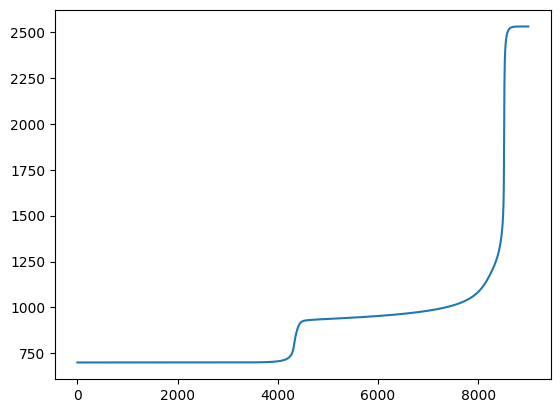

In [127]:
# bdf_results['bdf_results_low'] = run_integration_experiment(
#                 'cvode_bdf', gas, y0, t0, end_time, timestep,
#                 1e-6, 1e-8, species_to_track,
#                 fuel, pressure=gas.P,
#                 time_limit=time_limit,
#                 table_id=None
#             )

plt.plot(bdf_results['bdf_results_low']['temperatures'], label='HE-ERK')


In [130]:


# Loop through parameters and run experiments
for result_name, rtol, atol in run_params:
    gas, y0 = reset_gas(temperature, pressure, phi)
    method = 'cvode_bdf'
    
    results = run_integration_experiment(
                method, gas, y0, t0, end_time, timestep,
                rtol, atol, species_to_track,
                fuel, pressure=gas.P,
                time_limit=time_limit,
                table_id=None
            )
    
    bdf_results[result_name] = results
    

Running cvode_bdf-None with rtol=1e-08 and atol=1e-10: 100%|██████████| 0.009000999999999839/0.009 [00:37<00:00, 4180.97s/it, step=9001, temperature=2530.3K, cpu_time=1.27e-03s, total_cpu_time=2.49e+01s] 
Running cvode_bdf-None with rtol=1e-08 and atol=1e-08: 100%|██████████| 0.009000999999999839/0.009 [00:42<00:00, 4668.11s/it, step=9001, temperature=2534.6K, cpu_time=2.54e-03s, total_cpu_time=2.50e+01s] 
Running cvode_bdf-None with rtol=1e-06 and atol=1e-08: 100%|██████████| 0.009000999999999839/0.009 [00:44<00:00, 4933.03s/it, step=9001, temperature=2530.8K, cpu_time=3.03e-03s, total_cpu_time=2.39e+01s] 


In [131]:
method = 'arkode_erk'
table_id = SP.arkode.ButcherTable.HEUN_EULER_2_1_2
rtol, atol = 1e-6, 1e-8

pure_rk_results = run_integration_experiment(
                method, gas, y0, t0, end_time, timestep,
                rtol, atol, species_to_track,
                fuel, pressure=gas.P,
                time_limit=time_limit,
                table_id=table_id
            )

Running arkode_erk-ButcherTable.HEUN_EULER_2_1_2 with rtol=1e-06 and atol=1e-08:  31%|███       | 0.0027630000000000423/0.009 [00:09<00:20, 3343.54s/it, step=2762, temperature=771.4K, cpu_time=2.04e-02s, total_cpu_time=6.50e+00s]

Step 0.002762000000000042 failed: <built-in method solve_single of PyCapsule object at 0x7fe01ac75110> returned NULL without setting an exception
Step 2762 failed: <built-in method solve_single of PyCapsule object at 0x7fe01ac75110> returned NULL without setting an exception


[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1742999320892/work/sundials/src/arkode/arkode.c:808][ARKodeEvolve] At t = 0.00276296, mxstep steps taken before reaching tout.



In [132]:
pre_ignition_end_idx, ignition_start_idx, ignition_end_idx = detect_ignition_regions(bdf_results['reference']['temperatures'], bdf_results['reference']['times'])
print(pre_ignition_end_idx, ignition_start_idx, ignition_end_idx)

8508 8509 8550


In [138]:
switch_point = 1000
second_switch_point = 50000
method_dict = {
    0: ('arkode_erk', 1e-6, 1e-8, SP.arkode.ButcherTable.HEUN_EULER_2_1_2),
    switch_point: ('cvode_bdf', 1e-8, 1e-10, None),
    # second_switch_point: ('arkode_erk', 1e-6, 1e-8, SP.arkode.ButcherTable.HEUN_EULER_2_1_2),
}

rk_bdf_results = run_integration_with_switching(method_dict, gas, y0, t0, end_time, timestep, species_to_track, fuel, pressure, time_limit)

switch_points = [switch_point]


  2%|▏         | 0.0002189999999999995/0.009 [00:00<00:08, 958.61s/it, step=219, temperature=700.0K, cpu_time=5.92e-04s, total_cpu_time=6.54e-02s] 

Switching to arkode_erk at step 0 with rtol=1e-06 and atol=1e-08 and table_id=ButcherTable.HEUN_EULER_2_1_2


 12%|█▏        | 0.0010440000000000115/0.009 [00:01<00:11, 1396.00s/it, step=1044, temperature=700.0K, cpu_time=2.26e-03s, total_cpu_time=6.49e-01s]

Switching to cvode_bdf at step 1000 with rtol=1e-08 and atol=1e-10 and table_id=None


100%|█████████▉| 0.00899999999999984/0.009 [00:36<00:00, 4292.92s/it, step=9000, temperature=2530.3K, cpu_time=2.78e-03s, total_cpu_time=2.42e+01s]  /home/elo/miniforge3/envs/sundialEnv/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.009000999999999839/0.009 [00:36<00:00, 4054.82s/it, step=9001, temperature=2530.3K, cpu_time=5.65e-03s, total_cpu_time=2.42e+01s]


In [140]:
switch_points = [switch_point]

In [ ]:
# save the data
with open('bdf_results.pkl', 'wb') as f:
    pickle.dump(bdf_results, f)

with open('rk_bdf_results.pkl', 'wb') as f:
    pickle.dump(rk_bdf_results, f)

with open('pure_rk_results.pkl', 'wb') as f:
    pickle.dump(pure_rk_results, f)


In [142]:
def compare_single_species_performance(bdf_results, comparison_results, comparison_names=["Comparison"], 
                                     species_name='h2o', temperature=None, pressure=None, 
                                     switch_points=None, metric='mean', zoom_start=None, zoom_end=None):
    """
    Create high-quality comparison plots for a single species between BDF reference and comparison solvers.
    
    Args:
        bdf_results: Dictionary containing BDF solver results with keys:
                    - 'reference': high precision reference solution
                    - 'bdf_results_low': low tolerance BDF results  
                    - 'bdf_results_high': high tolerance BDF results
        comparison_results: List of Results dictionary for the comparison solver
        comparison_names: List of names for the comparison solver in plots
        species_name: Single species name to analyze
        temperature: Temperature for plot titles
        pressure: Pressure for plot titles
        switch_points: List of switch points for the comparison solver
        metric: 'mean' or 'max' for concentration analysis
        zoom_start: Start point for zoom plot (step number)
        zoom_end: End point for zoom plot (step number)
    """
    
    # Define plotting parameters
    colors = ['red', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    # Create subplot layout based on whether zoom is requested
    if zoom_start is not None and zoom_end is not None:
        fig, ((ax1, ax1_zoom), (ax2, ax2_zoom)) = plt.subplots(2, 2, figsize=(32, 22), dpi=300)
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20), dpi=300)
    
    # Plot BDF results
    if species_name == 'temperature':
        ref_data = bdf_results['reference']['temperatures']
        bdf_low_data = bdf_results['bdf_results_low']['temperatures']
        bdf_high_data = bdf_results['bdf_results_high']['temperatures']
    else:
        ref_data = bdf_results['reference']['species_profiles'][species_name]
        bdf_low_data = bdf_results['bdf_results_low']['species_profiles'][species_name]
        bdf_high_data = bdf_results['bdf_results_high']['species_profiles'][species_name]
    
    # Function to plot data on an axis
    def plot_species_data(ax, title_suffix="", is_zoom=False):
        if species_name == 'temperature':
            ax.plot(ref_data, label='Reference BDF (1e-12,1e-10)',
                    linestyle='-', linewidth=4 if is_zoom else 3, color='blue')
            ax.plot(bdf_low_data, label='BDF (1e-6,1e-8)',
                    linestyle='-', linewidth=3 if is_zoom else 2, color='green')
            ax.plot(bdf_high_data, label='BDF (1e-8,1e-10)',
                    linestyle='-', linewidth=3 if is_zoom else 2, color='black')
            ylabel = 'Temperature (K)'
        else:
            ax.plot(np.log10(np.maximum(ref_data, 1e-20)), label='Reference BDF (1e-12,1e-10)',
                    linestyle='-', linewidth=4 if is_zoom else 3, color='blue')
            ax.plot(np.log10(np.maximum(bdf_low_data, 1e-20)), label='BDF (1e-6,1e-8)',
                    linestyle='-', linewidth=3 if is_zoom else 2, color='green')
            ax.plot(np.log10(np.maximum(bdf_high_data, 1e-20)), label='BDF (1e-8,1e-10)',
                    linestyle='-', linewidth=3 if is_zoom else 2, color='black')
            ylabel = 'Log₁₀(Mole Fraction)'
        
        # Plot comparison results
        for i, (comparison_name, comparison_result) in enumerate(zip(comparison_names, comparison_results)):
            if species_name == 'temperature':
                species_data = comparison_result['temperatures']
                ax.plot(species_data, label=comparison_name,
                        linestyle='-', linewidth=3.5 if is_zoom else 2.5, color=colors[i])
            else:
                species_data = comparison_result['species_profiles'][species_name]
                ax.plot(np.log10(np.maximum(species_data, 1e-20)), label=comparison_name,
                        linestyle='-', linewidth=3.5 if is_zoom else 2.5, color=colors[i])

        # Add switch points
        if switch_points:
            for switch_point in switch_points:
                ax.axvline(x=switch_point, color='red', linestyle='--', alpha=0.7, 
                          linewidth=3 if is_zoom else 2)
        
        ax.set_xlabel('Step Number', fontsize=16 if is_zoom else 14)
        ax.set_ylabel(ylabel, fontsize=16 if is_zoom else 14)
        ax.set_title(f'{species_name.upper()} Profile Comparison{title_suffix}', 
                    fontsize=18 if is_zoom else 16, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14 if is_zoom else 12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=14 if is_zoom else 12)
        
        return ylabel
    
    # Plot 1: Species Profile Comparison (full range)
    ylabel = plot_species_data(ax1)
    
    # Plot 1 zoom: Species Profile Comparison (zoomed range)
    if zoom_start is not None and zoom_end is not None:
        ylabel_zoom = plot_species_data(ax1_zoom, f" (Zoom: {zoom_start}-{zoom_end})", is_zoom=True)
        ax1_zoom.set_xlim(zoom_start, zoom_end)
    
    # Plot 2: Concentration Accuracy Comparison
    def calculate_species_metric(data, ref_data, species_name, metric='mean', zoom_start=None, zoom_end=None):
        if species_name == 'temperature':
            if zoom_start is not None and zoom_end is not None:
                # Calculate metric only for the zoom region
                data_slice = data['temperatures'][zoom_start:zoom_end+1]
                ref_slice = ref_data['temperatures'][zoom_start:zoom_end+1]
            else:
                # Use full data but match lengths
                data_slice = data['temperatures']
                ref_slice = ref_data['temperatures'][:len(data['temperatures'])]
            
            conc = np.max(data_slice) if metric == 'max' else np.mean(data_slice)
            ref_conc = np.max(ref_slice) if metric == 'max' else np.mean(ref_slice)
        else:
            if zoom_start is not None and zoom_end is not None:
                # Calculate metric only for the zoom region
                data_slice = data['species_profiles'][species_name][zoom_start:zoom_end+1]
                ref_slice = ref_data['species_profiles'][species_name][zoom_start:zoom_end+1]
            else:
                # Use full data but match lengths
                data_slice = data['species_profiles'][species_name]
                ref_slice = ref_data['species_profiles'][species_name][:len(data['species_profiles'][species_name])]
            
            conc = np.max(data_slice) if metric == 'max' else np.mean(data_slice)
            ref_conc = np.max(ref_slice) if metric == 'max' else np.mean(ref_slice)
        
        return conc / ref_conc
    
    # Function to create bar chart
    def create_bar_chart(ax, title_suffix="", use_zoom=False):
        # Determine which zoom parameters to use
        z_start = zoom_start if use_zoom else None
        z_end = zoom_end if use_zoom else None
        
        # Calculate concentration ratios
        bdf_ratio_low = calculate_species_metric(bdf_results['bdf_results_low'], bdf_results['reference'], 
                                               species_name, metric, z_start, z_end)
        bdf_ratio_high = calculate_species_metric(bdf_results['bdf_results_high'], bdf_results['reference'], 
                                                species_name, metric, z_start, z_end)
        
        comp_ratios = []
        for comparison_result in comparison_results:
            comp_ratio = calculate_species_metric(comparison_result, bdf_results['reference'], 
                                                species_name, metric, z_start, z_end)
            comp_ratios.append(comp_ratio)
        
        solver_names = ['BDF\n(1e-6,1e-8)', 'BDF\n(1e-8,1e-10)'] + comparison_names
        ratios = [bdf_ratio_low, bdf_ratio_high] + comp_ratios
        bar_colors = ['green', 'black'] + colors[:len(comparison_names)]
        
        bars = ax.bar(solver_names, ratios, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Add reference line
        ax.axhline(y=1.0, color='blue', linestyle='--', linewidth=3, label='Reference BDF (1e-12,1e-10)')
        
        ax.set_ylabel(f'{metric.capitalize()} Concentration Ratio (Solver/Reference)', 
                     fontsize=16 if use_zoom else 14)
        ax.set_xlabel('Solver Configuration', fontsize=16 if use_zoom else 14)
        ax.set_yscale('log')
        ax.set_title(f'{species_name.upper()} Concentration Accuracy ({metric.capitalize()}){title_suffix}', 
                    fontsize=18 if use_zoom else 16, fontweight='bold')
        ax.legend(fontsize=14 if use_zoom else 12)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(labelsize=14 if use_zoom else 12)
    
    # Create bar chart for full range
    create_bar_chart(ax2)
    
    # Create bar chart for zoom range (if applicable)
    if zoom_start is not None and zoom_end is not None:
        create_bar_chart(ax2_zoom, f" (Zoom: {zoom_start}-{zoom_end})", use_zoom=True)
    
    # Overall figure title
    main_title = f'{species_name.upper()} Performance Analysis'
    if temperature and pressure:
        main_title += f' - {temperature}K, {pressure:.0e}Pa'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=0.98)
    
    # Use subplots_adjust for better control and spacing
    if zoom_start is not None and zoom_end is not None:
        plt.subplots_adjust(left=0.06, right=0.82, top=0.92, bottom=0.08, hspace=0.35, wspace=0.4)
    else:
        plt.subplots_adjust(left=0.08, right=0.85, top=0.92, bottom=0.08, hspace=0.3)
    plt.show()
compare_single_species_performance(bdf_results, [rk_bdf_results, pure_rk_results], comparison_names=["HE-BDF(1e-6,1e-8)-(1e-8,1e-10)", "HE"], 
                                     species_name='oh', temperature=temperature, pressure=pressure, 
                                     switch_points=switch_points, metric='mean', zoom_start=0, zoom_end=10000)

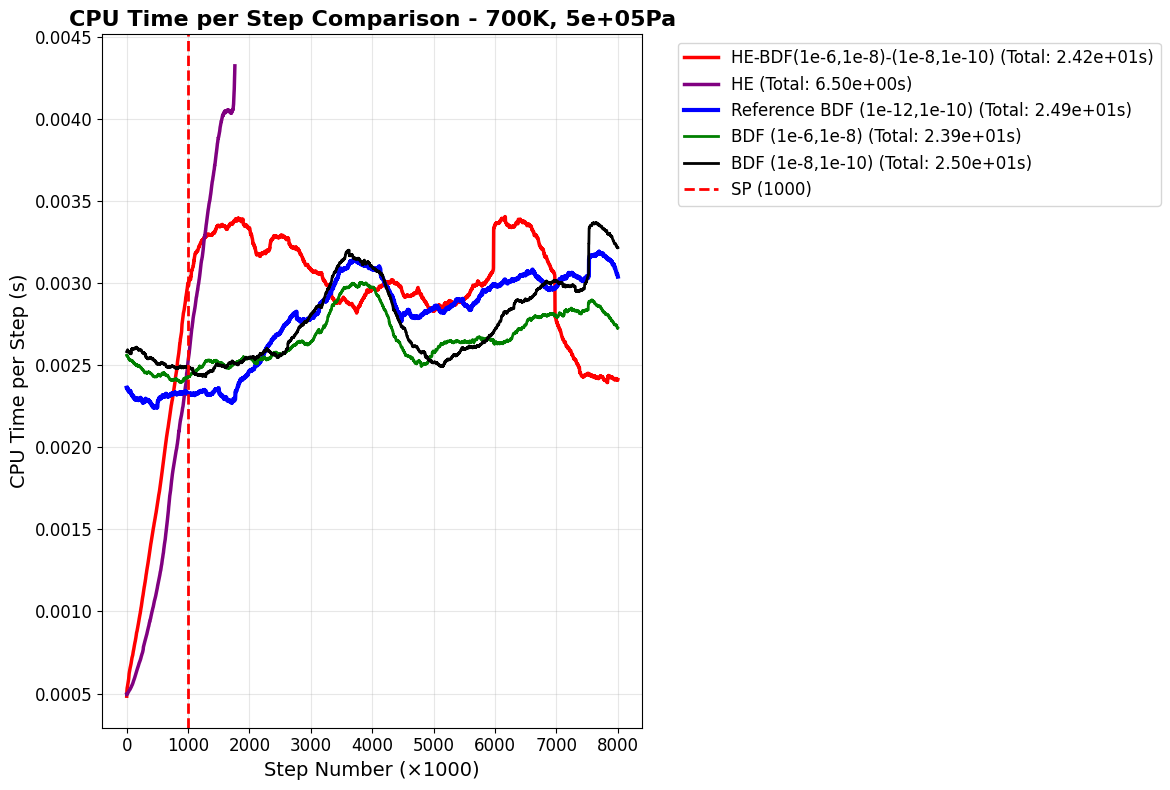

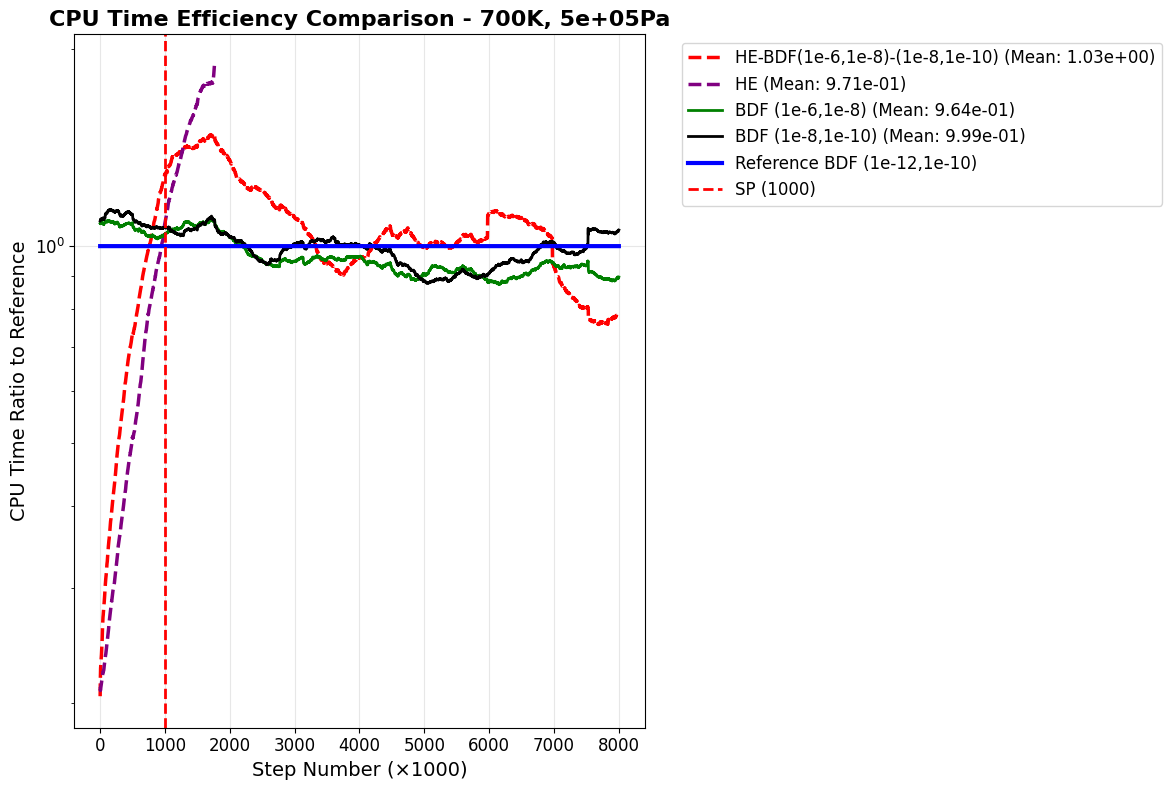

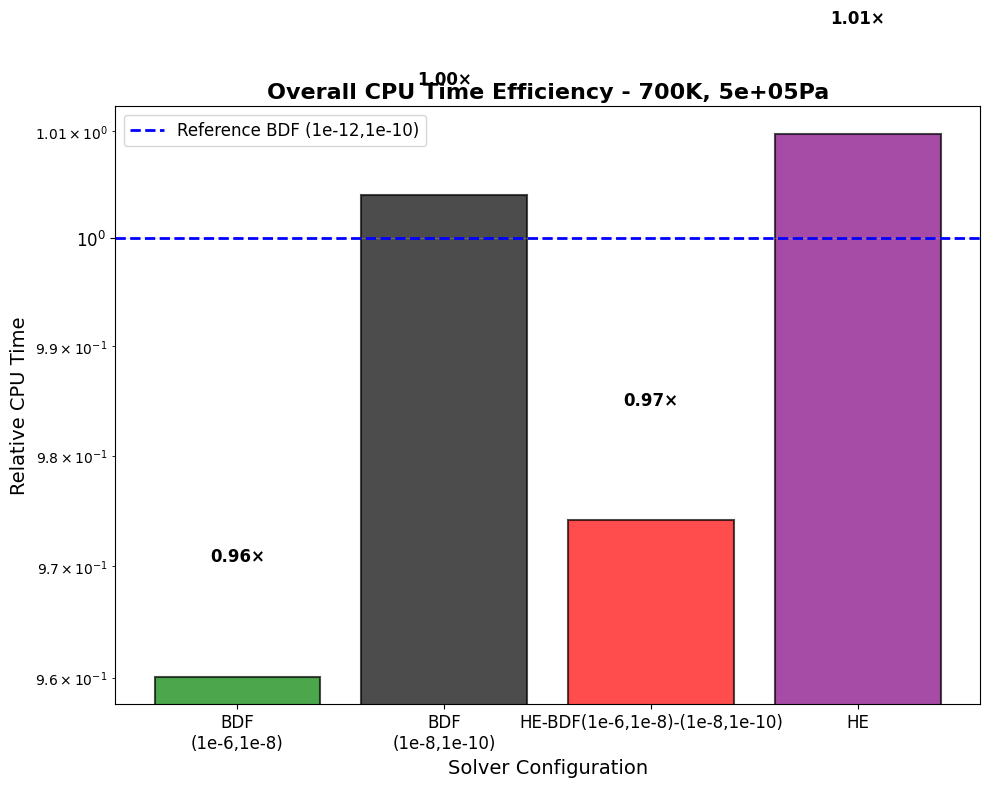

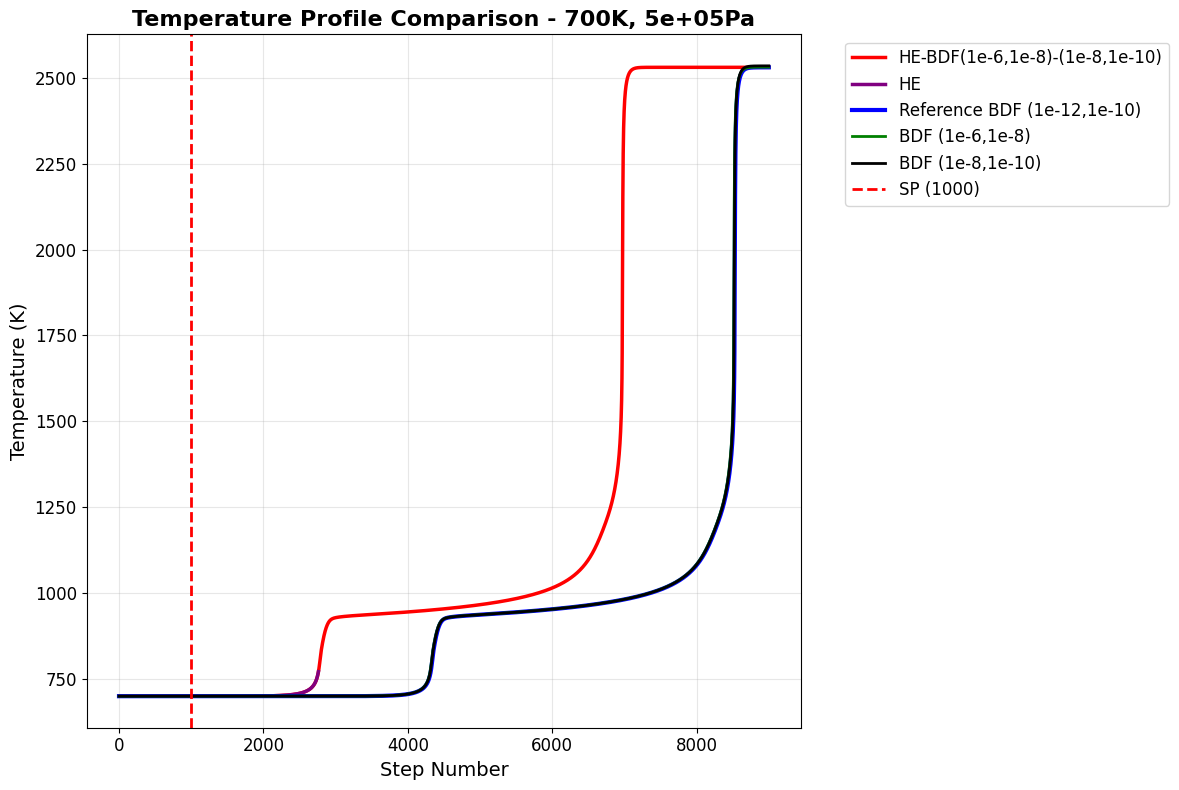

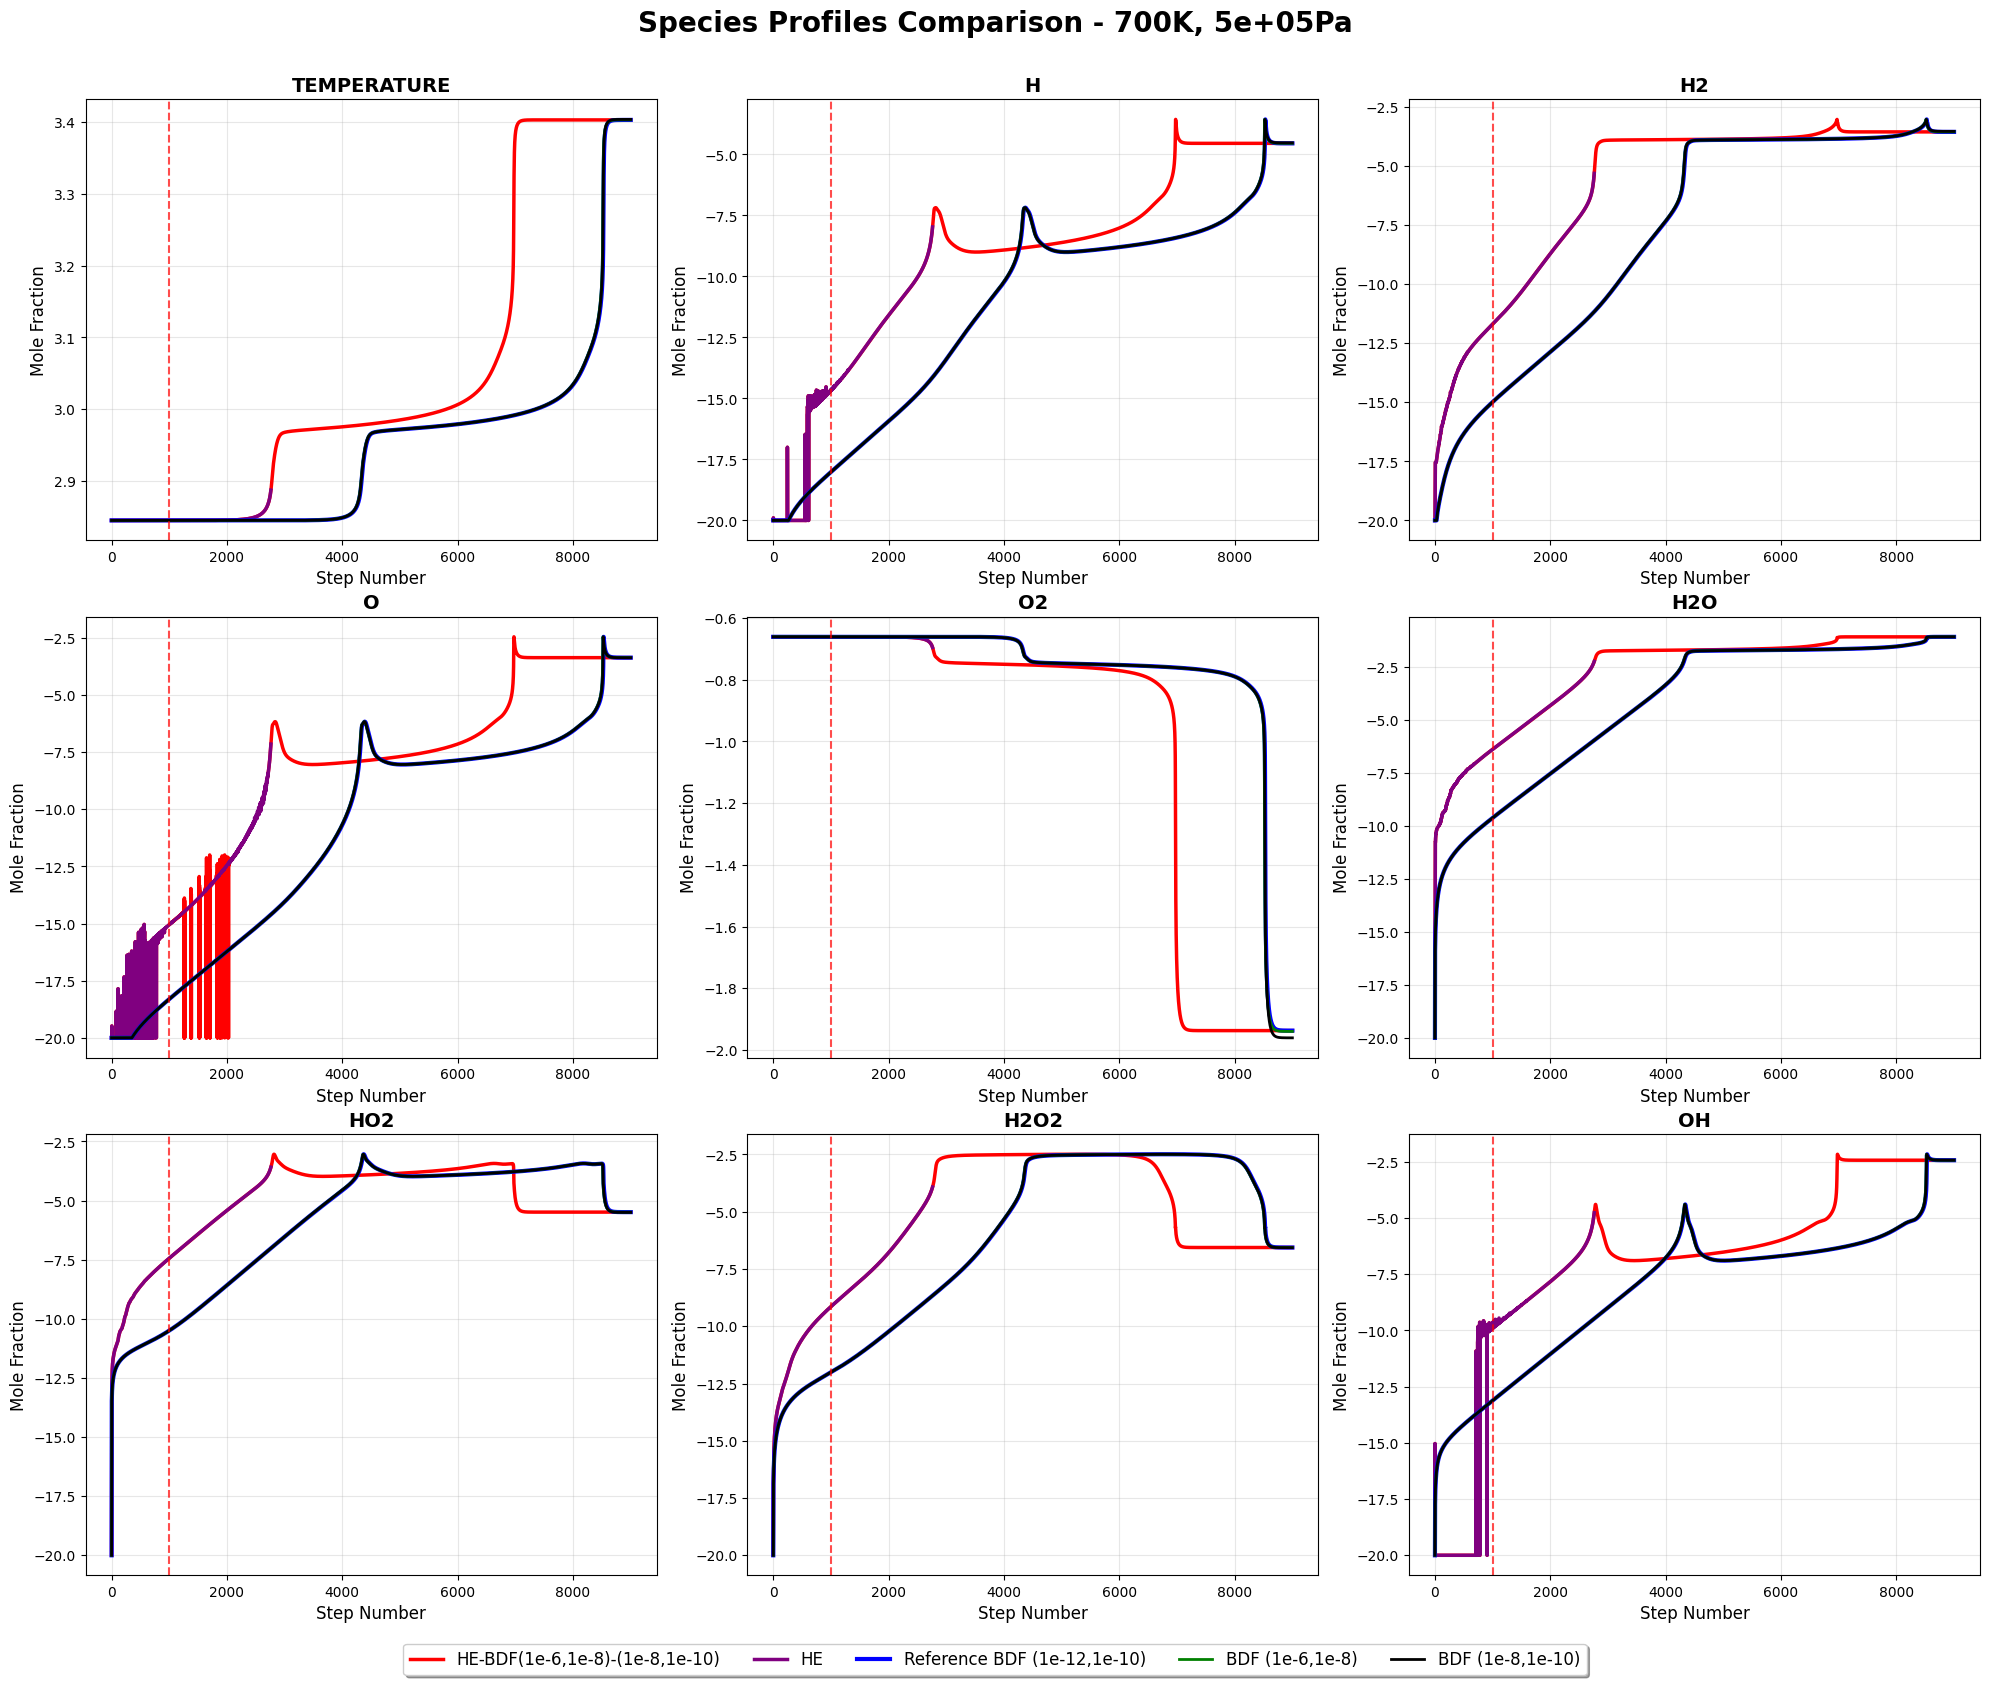

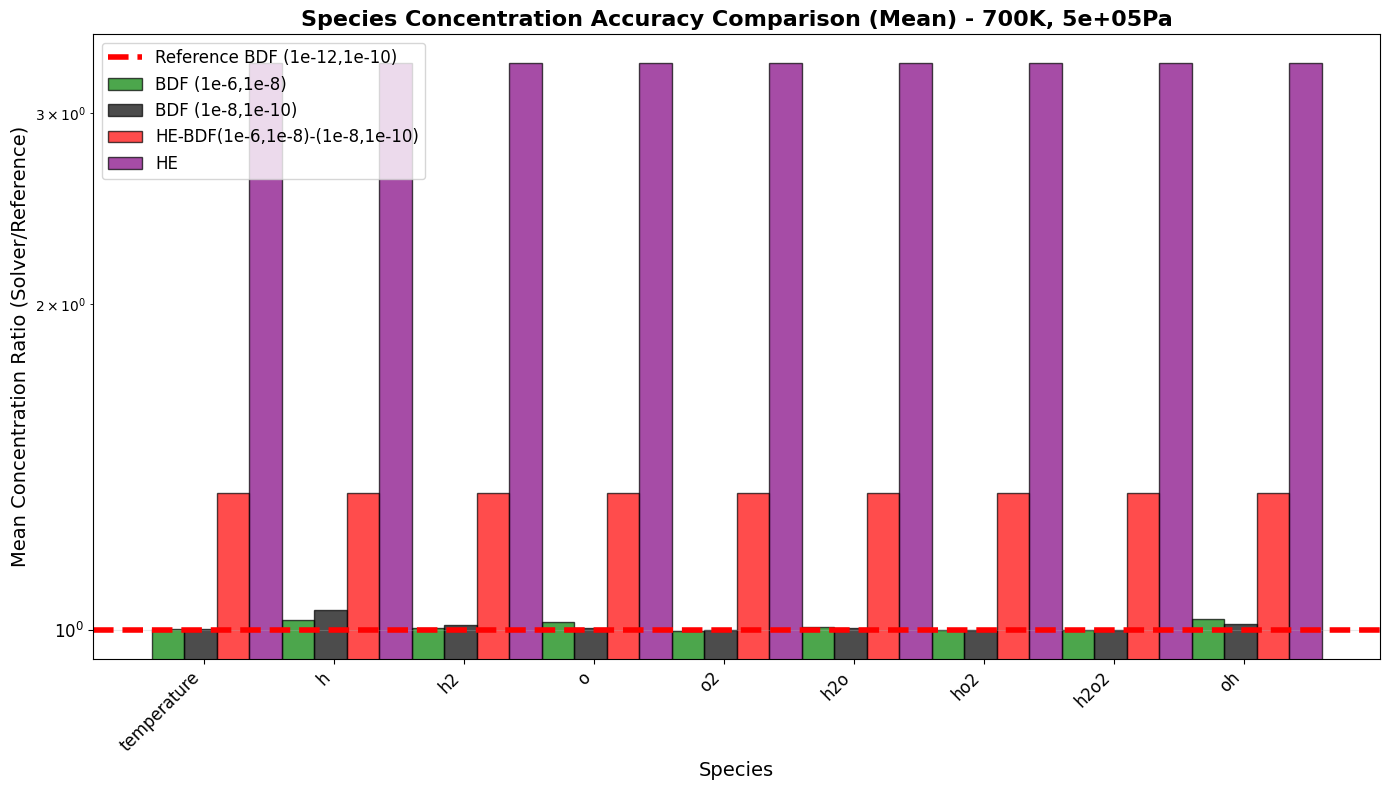

In [143]:
# Call the function with the existing data
species_to_plot = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
compare_solver_performance(bdf_results, [rk_bdf_results, pure_rk_results], ["HE-BDF(1e-6,1e-8)-(1e-8,1e-10)", "HE"], 
                         temperature=temperature, pressure=pressure, 
                         species_to_track=species_to_plot, switch_points=switch_points, metric='mean')

In [ ]:
# 

In [ ]:
# # PLOT THE CPU TIME OF THE IMPLICIT SOLVERS IN A 2x2 GRID
# line_styles = ['-', '--', '-.', ':'] * 10  # Repeat basic line styles
# colors = [ 'purple', 'orange', 'brown', 'pink',  'cyan', 'magenta', 'lime', 'teal', 'navy', 'gray', 'olive','maroon', 'gold', 'silver', 'indigo', 'turquoise']

# # Create figure with 2x2 subplots sharing x and y axes
# fig, ax = plt.subplots(figsize=(15, 10), dpi=200)

# # Plot each group in its own subplot
# for i, table_id in enumerate(solver_to_run):
#     # if table_id in solver_to_exclude:
#     #     continue
#     data = solvers_results_high[table_id]
#     if len(data['cpu_times']) < 100:
#         continue
#     ax.plot(
#         running_average_forward(data['cpu_times'], 1000),
#         label=f"{str(table_id)} high - {np.sum(data['cpu_times']):.2e}",
#         linestyle='--',
#         linewidth=2,
#         color=colors[i]
#     )
#     data = solvers_results_low[table_id]
#     ax.plot(
#         running_average_forward(data['cpu_times'], 1000),
#         label=f"{str(table_id)} low - {np.sum(data['cpu_times']):.2e}",
#         linestyle='-',
#         linewidth=2,
#         color=colors[i]
#     )
# ax.plot(
#     running_average_forward(bdf_results['reference']['cpu_times'], 1000    ),
#     label=f'Reference(1e-12,1e-10) - {np.sum(bdf_results['reference']['cpu_times']):.2e}',
#     linestyle='-',
#     linewidth=3,
#     color='red'
# )

# ax.plot(
#     running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000),
#     label=f'BDF(1e-6,1e-8) - {np.sum(bdf_results['bdf_results_low']['cpu_times']):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='blue'
# )

# ax.plot(
#     running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000),
#     label=f'BDF(1e-8,1e-10) - {np.sum(bdf_results['bdf_results_high']['cpu_times']):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='green'
# )
# # ax.set_title(f'Solvers {subplot_idx*6 + 1}-{min((subplot_idx+1)*6, 25)}')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

# # # Set common labels
# # fig.text(0.5, 0.04, 'Step Number', ha='center', va='center')
# # fig.text(0.06, 0.5, 'CPU Time (s)', ha='center', va='center', rotation='vertical')
# fig.suptitle(f'CPU Time per Step for Different Implicit Solvers - {temperature}K - {pressure}Pa', fontsize=16)

# plt.tight_layout()
# plt.show()


In [ ]:
# # PLOT THE CPU TIME OF THE IMPLICIT SOLVERS IN A 2x2 GRID
# line_styles = ['-', '--', '-.', ':'] * 10  # Repeat basic line styles
# colors = [ 'purple', 'orange', 'brown', 'pink',  'cyan', 'magenta', 'lime', 'teal', 'navy', 'gray', 'olive','maroon', 'gold', 'silver', 'indigo', 'turquoise']

# # Create figure with 2x2 subplots sharing x and y axes
# fig, ax = plt.subplots(figsize=(15, 10), dpi=200)

# # Get reference data
# reference_times = running_average_forward(bdf_results['reference']['cpu_times'], 1000)

# # Plot each group in its own subplot
# for i, table_id in enumerate(solver_to_run):
#     # High tolerance results
#     data = solvers_results_high[table_id]
#     solver_times = running_average_forward(data['cpu_times'], 1000)
#     if len(solver_times) < 100:
#         continue
#     ratio = solver_times / reference_times[:len(solver_times)]
#     ax.plot(
#         ratio,
#         label=f"{str(table_id)} high - {np.mean(ratio):.2e}",
#         linestyle='--',
#         linewidth=2,
#         color=colors[i]
#     )
    
#     # Low tolerance results
#     data = solvers_results_low[table_id]
#     solver_times = running_average_forward(data['cpu_times'], 1000)
#     ratio = solver_times / reference_times[:len(solver_times)]
#     ax.plot(
#         ratio,
#         label=f"{str(table_id)} low - {np.mean(ratio):.2e}",
#         linestyle='-',
#         linewidth=2,
#         color=colors[i]
#     )

# # Plot BDF ratios
# bdf_low_times = running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000)
# ratio = bdf_low_times / reference_times[:len(bdf_low_times)]
# ax.plot(
#     ratio,
#     label=f'BDF(1e-6,1e-8) - {np.mean(ratio):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='blue'
# )

# bdf_high_times = running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000)
# ratio = bdf_high_times / reference_times[:len(bdf_high_times)]
# ax.plot(
#     ratio,
#     label=f'BDF(1e-8,1e-10) - {np.mean(ratio):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='green'
# )

# # Plot reference ratio (always 1.0)
# ax.plot(
#     np.ones_like(reference_times),
#     label='Reference(1e-12,1e-10)',
#     linestyle='-',
#     linewidth=3,
#     color='red'
# )

# ax.set_yscale('log')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
# ax.set_ylabel('Ratio to Reference CPU Time', fontsize=14)
# ax.set_xlabel('Step Number (thousands)', fontsize=14)
# ax.grid(True)

# fig.suptitle(f'CPU Time Ratio per Step for Different Implicit Solvers - {temperature}K - {pressure}Pa', fontsize=16)

# plt.tight_layout()
# plt.show()

In [ ]:

bdf_results_errors = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_low'], species_to_track, use_log=False)

bdf_results_errors_high = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_high'], species_to_track, use_log=False)


rk_bdf_results_errors = calculate_rmse(bdf_results['reference'], rk_bdf_results, species_to_track, use_log=False)


In [ ]:
# solver_errors = {}
# solver_errors_high = {}
# explicit_solver_errors = {}
# species_to_track = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
# for table_id in solver_to_run:
#     if len(solvers_results_low[table_id]['cpu_times']) < 100:
#         continue
#     solver_errors[table_id] = calculate_rmse(bdf_results['reference'], solvers_results_low[table_id], species_to_track, use_log=False)
#     solver_errors_high[table_id] = calculate_rmse(bdf_results['reference'], solvers_results_high[table_id], species_to_track, use_log=False)


# bdf_results_errors = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_low'], species_to_track, use_log=False)

# bdf_results_errors_high = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_high'], species_to_track, use_log=False)



In [ ]:
solver_to_exclude = [SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.ARK324L2SA_ERK_4_2_3, SP.arkode.ButcherTable.ARK437L2SA_DIRK_7_3_4, SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3, SP.arkode.ButcherTable.CASH_5_3_4, SP.arkode.ButcherTable.HEUN_EULER_2_1_2]


In [ ]:
solver_to_plot = [SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3, SP.arkode.ButcherTable.ARK2_DIRK_3_1_2, SP.arkode.ButcherTable.TRBDF2_3_3_2]

In [ ]:
# Create one large figure with subplots for all species
fig, axes = plt.subplots(3, 3, figsize=(30, 30), dpi=300)

for i, specie_name in enumerate(species_to_track):
    ax = axes[i // 3, i % 3]
    ax.plot(running_average_forward(np.maximum(bdf_results_errors_high[specie_name], 1e-20), 1000),
            label=f"BDF(1e-8,1e-10)", 
            linestyle='-',
            linewidth=2,
                color='blue')
    ax.plot(running_average_forward(np.maximum(rk_bdf_results_errors[specie_name], 1e-20), 1000),
            label=f"rk_bdf", 
            linestyle='--',
            linewidth=2,
                color='red')
        
    ax.plot(running_average_forward(np.maximum(bdf_results_errors[specie_name], 1e-20), 1000),
            label=f"BDF(1e-6,1e-8)", 
            linestyle='-',
            linewidth=2,
                color='green')
    
    ax.set_title(f'{specie_name}')
    ax.set_yscale('log')
    ax.grid(True)
    if i == len(species_to_track) - 1:  # Only show legend on last plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

fig.suptitle('RMSE for Different Species Across All Implicit Solvers', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# # Create one large figure with subplots for all species
# fig, axes = plt.subplots(3, 3, figsize=(30, 30), dpi=300)

# for i, specie_name in enumerate(species_to_track):
#     ax = axes[i // 3, i % 3]
#     ax.plot(running_average_forward(np.maximum(bdf_results_errors_high[specie_name], 1e-20), 1000),
#             label=f"BDF(1e-8,1e-10)", 
#             linestyle='-',
#             linewidth=2,
#                 color='blue')
#     for j, table_id in enumerate(solver_to_plot):
#         if len(solver_errors_high[table_id][specie_name]) < 100:
#             continue
#         data = solver_errors_high[table_id]
#         ax.plot(running_average_forward(np.maximum(data[specie_name], 1e-20), 1000),
#             label=f"{str(table_id)}", 
#             linestyle='--',
#             linewidth=2,
#                 color=colors[i])
        
#         data = solver_errors[table_id]
#         ax.plot(running_average_forward(np.maximum(data[specie_name], 1e-20), 1000),
#             label=f"{str(table_id)}", 
#             linestyle='-',
#             linewidth=2,
#                 color=colors[i])
        
#     ax.plot(running_average_forward(np.maximum(bdf_results_errors[specie_name], 1e-20), 1000),
#             label=f"BDF(1e-6,1e-8)", 
#             linestyle='-',
#             linewidth=2,
#                 color='red')
    
#     ax.set_title(f'{specie_name}')
#     ax.set_yscale('log')
#     ax.grid(True)
#     if i == len(species_to_track) - 1:  # Only show legend on last plot
#         ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

# fig.suptitle('RMSE for Different Species Across All Implicit Solvers', fontsize=16)
# plt.tight_layout()
# plt.show()


In [ ]:
solver_to_run = solver_to_plot

In [ ]:
# def calculate_maximum_species_conc(data, ref_data, species_name):
#     max_concentrations = {}
#     for specie in species_name:
#         if specie == 'temperature':
#             max_conc = np.mean(data['temperatures'])
#             ref_max_conc = np.mean(ref_data['temperatures'])
#         else:
#             max_conc = np.mean(data['species_profiles'][specie])
#             ref_max_conc = np.mean(ref_data['species_profiles'][specie])
#         max_concentrations[specie] = (max_conc, ref_max_conc)
#     return max_concentrations

# solver_max_conc = {}
# solver_max_conc_high = {}

# species_to_track = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
# for table_id in solver_to_run:
#     if len(solvers_results_low[table_id]['cpu_times']) < 100:
#         continue
#     solver_max_conc[table_id] = calculate_maximum_species_conc(solvers_results_low[table_id], bdf_results['reference'], species_to_track)
#     solver_max_conc_high[table_id] = calculate_maximum_species_conc(solvers_results_high[table_id], bdf_results['reference'], species_to_track)


# bdf_max_conc = calculate_maximum_species_conc(bdf_results['reference'], bdf_results['bdf_results_low'], species_to_track)

# bdf_max_conc_high = calculate_maximum_species_conc(bdf_results['reference'], bdf_results['bdf_results_high'], species_to_track)





In [ ]:
# Create a figure for plotting max concentration ratios
fig, ax = plt.subplots(figsize=(20, 10), dpi=200)

# Track x-axis positions and labels
x_positions = []
x_labels = []
current_x = 0
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'navy', 'gray', 'olive', 'maroon', 'gold', 'silver', 'indigo', 'turquoise']
# Plot for each species

for specie_name in species_to_plot:
    # Plot BDF results
    bdf_ratio_low = bdf_max_conc[specie_name][0] / bdf_max_conc[specie_name][1]
    bdf_ratio_high = bdf_max_conc_high[specie_name][0] / bdf_max_conc_high[specie_name][1]
    
    ax.scatter(current_x, bdf_ratio_low, color='red', s=200, label='BDF (1e-6,1e-8)' if specie_name == species_to_track[0] else "")
    ax.scatter(current_x, bdf_ratio_high, color='black', s=200, label='BDF (1e-8,1e-10)' if specie_name == species_to_track[0] else "")
    
    # Plot other solver results
    rk_bdf_ratio = rk_bdf_max_conc[specie_name][0] / rk_bdf_max_conc[specie_name][1]
        
    ax.scatter(current_x, rk_bdf_ratio, color='blue', s=200, 
              label=f"rk_bdf" if specie_name == species_to_track[0] else "")
    
    x_positions.append(current_x)
    x_labels.append(specie_name)
    current_x += 1
# Customize plot
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, fontsize=24)
ax.set_xlabel('Species', fontsize=24)
# ax.set_yticklabels([f'{i:.2e}' for i in ax.get_yticks()], fontsize=24)
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Max Concentration Ratio (Solver/Reference)', fontsize=14)
ax.set_title(f'Maximum Concentration Ratios for Different Species and Solvers - {temperature}K - {pressure}Pa', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.show()
